In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import scipy.signal
import nc_time_axis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
sn.set_context("paper",font_scale=1.2)
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import zipfile
import palettable

# get my own stats functions
from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
## matplotlib RCparams setup

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',list(get_palette.Petroff10().to_sn_palette()))
matplotlib.rcParams['font.family']='Helvetica Neue'
matplotlib.rcParams['legend.frameon']=False
plt.rcParams['pdf.fonttype'] = 42

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

### get meta & lsm for ExSamples, UKCP

In [4]:
## ExSamples data location:
ExS_dataloc = '../../ExSamples_product/20210622/'

## create a run_info dataframe
run_info = pd.DataFrame(data=[['05','10','15'],['2072','2068','2066'],['r001i1p01554','r001i1p02242','r001i1p02868'],['hot','wet','hot']],
                        index=['ensemble_member','year','run','type'],columns=['fut_2072','fut_2068','fut_2066']).T

run_info['label'] = ['HOT2','WET','HOT1']

## get land sea masks
ExS_GBR_lsm = xr.open_dataarray('../ancil/ExS_GBR_lsm.nc')
UKCP_GBR_lsm = xr.open_dataarray('../ancil/UKCP_GBR_lsm.nc',decode_times=False)
UKCP_glob_lsm = xr.open_dataarray('../ancil/UKCP_lsm.nc',decode_times=False).astype(bool)

## create a dict of UKCP PPE experiment subsamples
UKCP_experiment_list = {}
UKCP_experiment_list[10] = ['0000','1113','1554','1649','1843','1935','2123','2242','2491','2868']
UKCP_experiment_list[12] = ['0000','1113','1554','1649','1843','1935','2123','2242','2305','2335','2491','2868']
UKCP_experiment_list[15] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2305', '2335', '2491', '2832', '2868']
UKCP_experiment_list[13] = ['0000', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2123', '2242', '2491', '2832', '2868']
UKCP_experiment_list[20] = ['0000', '0090', '0605', '0834', '1113', '1554', '1649', '1843', '1935', '2089', '2123', '2242', '2305', '2335', '2491', '2753', '2832', '2868', '2884', '2914']

## create a colour palette if required.
choose_palette = [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]

## other options:
### IBM color blind
# [matplotlib.colors.to_hex(get_palette.IBM_color_blind().to_sn_palette()[i]) for i in [2,0,3]]
### Petroff 6
# [matplotlib.colors.to_hex(get_palette.Petroff6().to_sn_palette()[i]) for i in [1,0,2]]
### tab10
# [matplotlib.colors.to_hex(get_palette.tab10().to_sn_palette()[i]) for i in [1,0,2]]

winter_colors = pd.Series(index=['1554','2242','2868'],data=choose_palette)

## Get Data

In [5]:
def preproc_sst(ds):
    name = ds.encoding["source"].split('/')[-1].split('_')[1]
    ds = ds.expand_dims({'ensemble_member_id':[name]})
    ds = ds.sel(time=ds['time.month'].isin([12,1,2])).resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')
    return ds

sst_ds = xr.open_mfdataset(glob.glob('../../UKCP_hadgem3_data/sst/*.nc'),preprocess=preproc_sst).sel(ensemble_member_id=['r001i1p0'+x for x in UKCP_experiment_list[15]])
sic_ds = xr.open_mfdataset(glob.glob('../../UKCP_hadgem3_data/sic/*.nc'),preprocess=preproc_sst).sel(ensemble_member_id=['r001i1p0'+x for x in UKCP_experiment_list[15]])

/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=wh

In [6]:
## reassign lsm coords to match data coords
UKCP_glob_lsm = UKCP_glob_lsm.assign_coords(latitude=sst_ds.latitude,longitude=sst_ds.longitude)

In [7]:
## compute required data

### SST
selected_sst_data = sst_ds.surface_temperature.sel(ensemble_member_id=run_info.run.values,time=sst_ds['time.year'].isin([2065,2067,2071])).compute()
all_sst_baseline = sst_ds.surface_temperature.sel(time=slice('2006-12','2015-12')).mean(['time','ensemble_member_id']).compute()
fut_sst_baseline = sst_ds.surface_temperature.sel(time=slice('2060-12','2079-12')).mean(['time','ensemble_member_id']).compute()
selected_sst_baseline = sst_ds.surface_temperature.sel(time=slice('2006-12','2015-12'),ensemble_member_id=run_info.run.values).mean('time').compute()

### SIC
selected_sic_data = sic_ds.sea_ice_area_fraction.sel(ensemble_member_id=run_info.run.values,time=sst_ds['time.year'].isin([2065,2067,2071])).compute()
all_sic_baseline = sic_ds.sea_ice_area_fraction.sel(time=slice('2006-12','2015-12')).mean(['time','ensemble_member_id']).compute()
fut_sic_baseline = sic_ds.sea_ice_area_fraction.sel(time=slice('2060-12','2079-12')).mean(['time','ensemble_member_id']).compute()
selected_sic_baseline = sic_ds.sea_ice_area_fraction.sel(time=slice('2006-12','2015-12'),ensemble_member_id=run_info.run.values).mean('time').compute()

/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [8]:
### compute detrended residuals
sst_data_to_detrend = sst_ds.surface_temperature.sel(ensemble_member_id=run_info.run.values,time=slice('2060','2079')).values

In [9]:
### detrend
sst_olse = OLSE.simple(sst_data_to_detrend)
sst_olse.fit(np.arange(20)[:,None,None,None])

sst_deviations = xr.full_like(sst_ds.surface_temperature.sel(ensemble_member_id=run_info.run.values,time=slice('2060','2079')),0) + sst_olse.res

### Get mslp

In [10]:
def preproc_UKCP_psl(ds):
    # select area used for analogs
    ds = ds.squeeze().sel(latitude=slice(10,80),longitude=slice(-60,60)).expand_dims('ensemble_member_id')
    # average over DJF
    ds = ds.sel(time = ds['time.month'].isin([12,1,2])).resample(time='QS-DEC').mean()
    ds = ds.sel(time = ds['time.month']==12)
    # reassign ensemble member ids for easy slicing
    ds = ds.assign_coords(ensemble_member_id=[x.decode().split('-')[-1] for x in ds.ensemble_member_id.values.tolist()])
    return ds

UKCP_psl = xr.open_mfdataset(['/badc/ukcp18/data/land-gcm/global/60km/rcp85/'+x+'/psl/mon/latest/psl_rcp85_land-gcm_global_60km_'+x+'_mon_189912-209911.nc' for x in run_info.ensemble_member.values],preprocess=preproc_UKCP_psl)

/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=wh

In [11]:
## create anomaly fields:
### UKCP
UKCP_1554_anom = (UKCP_psl.sel(ensemble_member_id='r001i1p01554',time='2071').squeeze() - UKCP_psl.sel(ensemble_member_id='r001i1p01554',time=slice('1996','2025')).mean('time')).psl.compute()
UKCP_2242_anom = (UKCP_psl.sel(ensemble_member_id='r001i1p02242',time='2067').squeeze() - UKCP_psl.sel(ensemble_member_id='r001i1p02242',time=slice('1996','2025')).mean('time')).psl.compute()
UKCP_2868_anom = (UKCP_psl.sel(ensemble_member_id='r001i1p02868',time='2065').squeeze() - UKCP_psl.sel(ensemble_member_id='r001i1p02868',time=slice('1996','2025')).mean('time')).psl.compute()

/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/njleach/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [12]:
selected_mslp_anomalies = xr.concat([UKCP_1554_anom,UKCP_2242_anom,UKCP_2868_anom],dim='ensemble_member_id')

## Plot figure

''

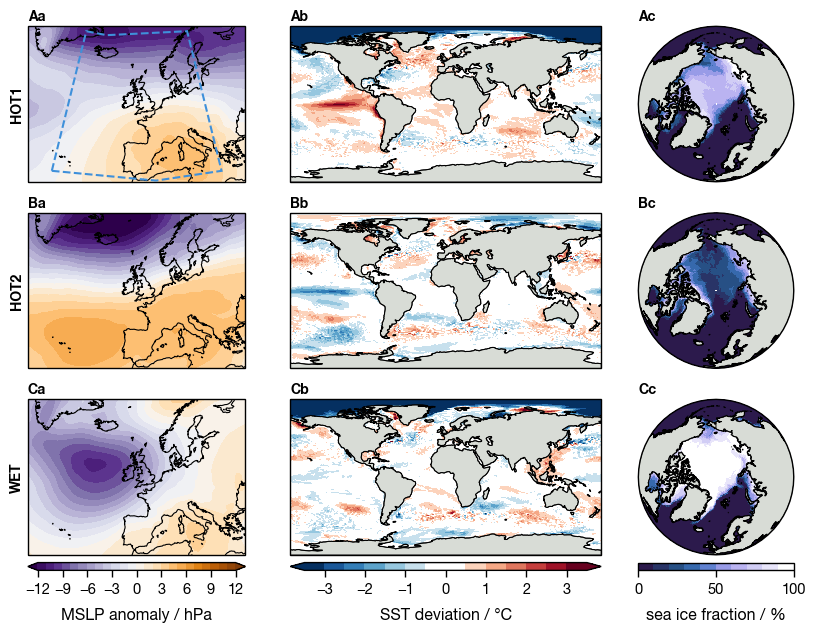

In [13]:
fig = plt.figure(figsize=(10.3,7))
gs = fig.add_gridspec(3,31,hspace=0.2,wspace=0.0)

msl_ax = [fig.add_subplot(gs[i,:10],projection=crs.AlbersEqualArea(central_longitude=-5, central_latitude=52.5)) for i in np.arange(3)]
sst_ax = [fig.add_subplot(gs[i,10:24],projection=crs.PlateCarree()) for i in np.arange(3)]
sic_ax = [fig.add_subplot(gs[i,24:],projection=crs.NearsidePerspective(central_longitude=0,central_latitude=90,satellite_height=5000000)) for i in np.arange(3)]

# msl cmap
nlev = 24
vrange=[0,1]
cmap_base = palettable.scientific.diverging.Broc_12.mpl_colormap(np.linspace(0,1,nlev))
cmap_base[11:13,:3]/=cmap_base[11:13,:3]
msl_cmap = matplotlib.colors.ListedColormap(cmap_base)

# sst cmap
nlev = 14
vrange=[0,1]
cmap_base = matplotlib.cm.RdBu_r(np.linspace(0,1,nlev))
cmap_base[6:8,:3]/=cmap_base[6:8,:3]
sst_cmap = matplotlib.colors.ListedColormap(cmap_base)

# sic cmap
nlev = 10
vrange=[0,1]
cmap_base = palettable.scientific.sequential.Devon_10.get_mpl_colormap()(np.linspace(0,1,nlev))
# cmap_base[4:6,:3]/=cmap_base[4:6,:3]
sic_cmap = matplotlib.colors.ListedColormap(cmap_base)

for i,winter in enumerate(['fut_2066','fut_2072','fut_2068']):
    
    winter_year = str(int(run_info.loc[winter,'year'])-1)
    winter_id = run_info.loc[winter,'run']
    
    ## msl anomalies
    p_msl=selected_mslp_anomalies.sel(ensemble_member_id=winter_id).plot.contourf(ax=msl_ax[i],add_colorbar=False,levels=25,extend='both',cmap='PuOr_r',vmin=-12,vmax=12,transform=crs.PlateCarree())
    
    ## SST anomalies
#     p_sst=(selected_sst_data.sel(time=winter_year,ensemble_member_id=winter_id)-all_sst_baseline).where(~UKCP_glob_lsm).plot(ax=sst_ax[i],add_colorbar=False,extend='both',cmap=sst_cmap,vmin=-7,vmax=7,transform=crs.PlateCarree())
    
    ## SST deviations
    p_sst=sst_deviations.sel(time=winter_year,ensemble_member_id=winter_id).where(~UKCP_glob_lsm).plot(ax=sst_ax[i],add_colorbar=False,extend='both',cmap=sst_cmap,vmin=-3.5,vmax=3.5,transform=crs.PlateCarree())
    
    p_sic=((selected_sic_data.sel(time=winter_year,ensemble_member_id=winter_id))*100).where(~UKCP_glob_lsm).plot(ax=sic_ax[i],add_colorbar=False,cmap=sic_cmap,vmin=0,vmax=100,transform=crs.PlateCarree())
    
    msl_ax[i].text(-0.05,0.5,run_info.loc[winter,'label'],va='center',ha='center',transform=msl_ax[i].transAxes,rotation=90,fontweight='bold')
    
axins = inset_axes(msl_ax[-1], width="100%",height="5%",loc='lower right',bbox_to_anchor=(0.00, -0.1, 1, 1),bbox_transform=msl_ax[-1].transAxes,borderpad=0)
cbar = plt.colorbar(p_msl,cax=axins,orientation='horizontal')
cbar.set_label('MSLP anomaly / hPa',labelpad=8)
    
axins = inset_axes(sst_ax[-1], width="100%",height="5%",loc='lower right',bbox_to_anchor=(0.00, -0.1, 1, 1),bbox_transform=sst_ax[-1].transAxes,borderpad=0)
cbar = plt.colorbar(p_sst,cax=axins,orientation='horizontal',extend='both')
cbar.set_label('SST deviation / \N{DEGREE SIGN}C',labelpad=8)

axins = inset_axes(sic_ax[-1], width="100%",height="5%",loc='lower right',bbox_to_anchor=(0.00, -0.1, 1, 1),bbox_transform=sic_ax[-1].transAxes,borderpad=0)
cbar = plt.colorbar(p_sic,cax=axins,orientation='horizontal')
cbar.set_label('sea ice fraction / %',labelpad=8)

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='k',
                                        facecolor='xkcd:light grey')

msl_ax[0].add_patch(mpatches.Rectangle(xy=[-30, 35], width=50, height=35,fill=False,lw=1.5,color=get_palette.Petroff10().to_sn_palette()[0],ls='--',transform=crs.PlateCarree(),zorder=3))

[a.add_feature(land_50m,linewidth=0.5) for a in sst_ax+sic_ax]

[a.coastlines() for a in msl_ax+sst_ax+sic_ax]

[a.set_xlim(-2800000,2800000) for a in msl_ax]
[a.set_ylim(-2000000,2000000) for a in msl_ax]

[a.set_title('') for a in msl_ax+sst_ax+sic_ax]

# add subplot labels
[[axs[j].text(0,1.02,['A','B','C'][j]+['a','b','c'][i],transform=axs[j].transAxes,va='bottom',ha='left',fontweight='bold') for i,axs in enumerate([msl_ax,sst_ax,sic_ax])] for j in np.arange(3)]


fig.dpi=100

[fig.savefig('../output/figs/FIG2.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf']]
''

This currently shows the DJF mean mslp anomalies over the region of importance; SST deviations relative to the 2061-2080 trend; and the absolute SICs.